<a href="https://colab.research.google.com/github/GVSU-CIS635/projects-team-1-1/blob/main/Project_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing packages

In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes  import GaussianNB
from sklearn.ensemble     import RandomForestClassifier
from xgboost              import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.base import clone
from sklearn.preprocessing import label_binarize


# Data Collection

In [103]:
# Data Loading
df_train = pd.read_csv("https://raw.githubusercontent.com/GVSU-CIS635/projects-team-1-1/main/data/train.csv", sep=";", skipinitialspace=True)
df_test = pd.read_csv("https://raw.githubusercontent.com/GVSU-CIS635/projects-team-1-1/main/data/test.csv", sep=";", skipinitialspace=True)


# Missing Values

In [104]:
# looking for missing data
print("Missing values found in Train\n", df_train.isnull().sum())

# looking for duplicate data
print("Duplicates found in Train ", df_train.duplicated().sum())

print("---------------------------------------------------------")
# looking for missing data
print("Missing values found in test\n", df_train.isnull().sum())

# looking for duplicate data
print("Duplicates found in test:", df_train.duplicated().sum())

Missing values found in Train
 age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64
Duplicates found in Train  0
---------------------------------------------------------
Missing values found in test
 age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64
Duplicates found in test: 0


Even though the source has already stated that the data has no missing values or duplicates, it is still good to verify this, since these steps affect all the later processes.

# Checking if Test is a subset of Train

In [105]:
# Creating a boolean mask: for each test row, check if it appears in train
mask = df_test.merge(df_train.drop_duplicates(),
                     how='left',
                     indicator=True)['_merge'] == 'both'


In [106]:
num_test = len(df_test)
num_matches = mask.sum()
num_missing = num_test - num_matches
percent_match = num_matches / num_test * 100

print(f"Test rows: {num_test}")
print(f"Rows that appear in train: {num_matches}")
print(f"Rows NOT found in train: {num_missing}")
print(f"Percent of test that is in train: {percent_match:.2f}%")

Test rows: 4521
Rows that appear in train: 4521
Rows NOT found in train: 0
Percent of test that is in train: 100.00%


Since test is a subset of train we can use training data to split into train(70%) and test(30%) and use it for models.

# Data Cleaning

In [107]:
def prepare_external_minimal(df_ext: pd.DataFrame) -> pd.DataFrame:

    # making a copy
    dfx = df_ext.copy()

    # Normalize headers
    dfx.columns = dfx.columns.str.strip().str.lower()

    if "duration" in dfx.columns:
        dfx = dfx.drop(columns=["duration"])

    # Fix mixed-type categorical columns
    cat_cols_train = df_train.select_dtypes(include=["object"]).columns.tolist()
    for c in cat_cols_train:
        df_train[c] = df_train[c].astype(str)

    dfx["contacted_before"] = (dfx["pdays"] != -1).astype(int)
    dfx["pdays_numeric"]     = dfx["pdays"].replace(-1, 0)
    for col in bin_features + ["y"]:
        if col in dfx.columns:
            dfx[col] = dfx[col].map({"yes": 1, "no": 0})
    return dfx

In [108]:
df_train = prepare_external_minimal(df_train)
df_test  = prepare_external_minimal(df_test)

# Feature Group Classification

In [109]:
# Define feature groups
num_features = ["age", "balance", "day", "campaign", "pdays_numeric", "previous"]
cat_features = ["job", "marital", "education", "contact", "month", "poutcome"]
bin_features = ["default", "housing", "loan"]  # yes/no strings

In [110]:
# Remove target column from lists (if present)
if "y" in num_features: num_features.remove("y")
if "y" in cat_features: cat_features.remove("y")
if "y" in bin_features: bin_features.remove("y")

# Numeric Features Visualization

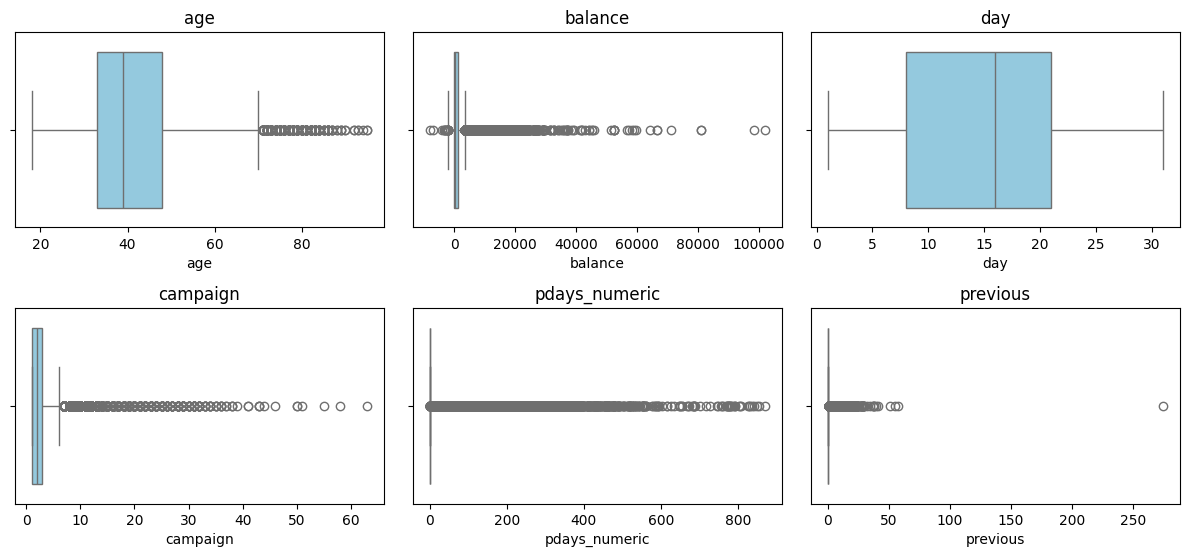

In [ ]:
# Box plot
plt.figure(figsize=(12,8))
for i, col in enumerate(num_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x = df_train[col], color="skyblue")
    plt.title(f"{col}")
plt.tight_layout()
plt.show()

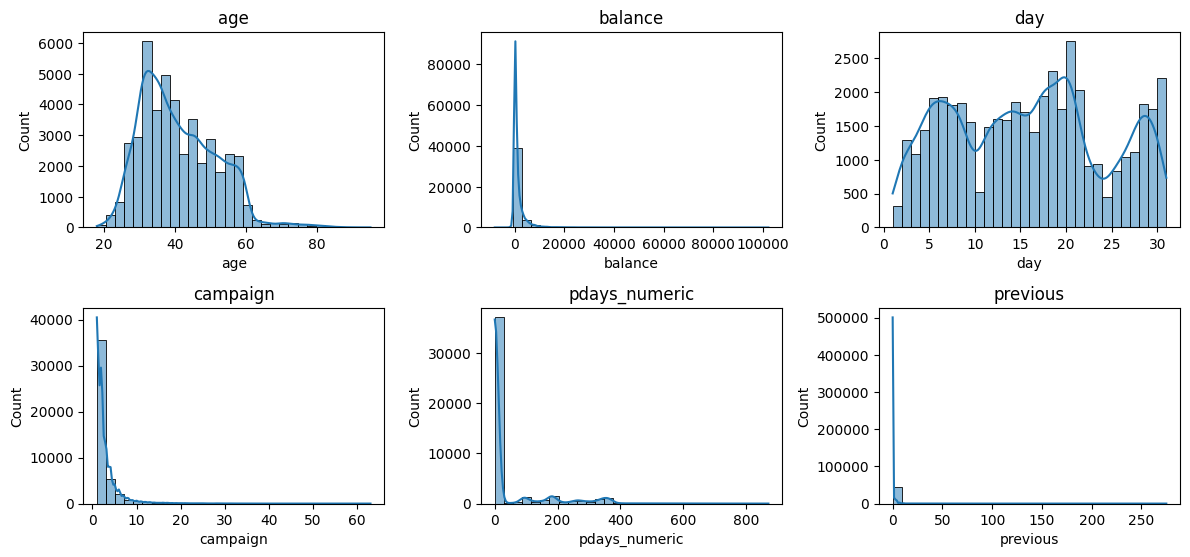

In [ ]:
# Distribution
plt.figure(figsize=(12,8))
for i, col in enumerate(num_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_train[col], bins=30, kde=True)
    plt.title(f"{col}")
plt.tight_layout()
plt.show()

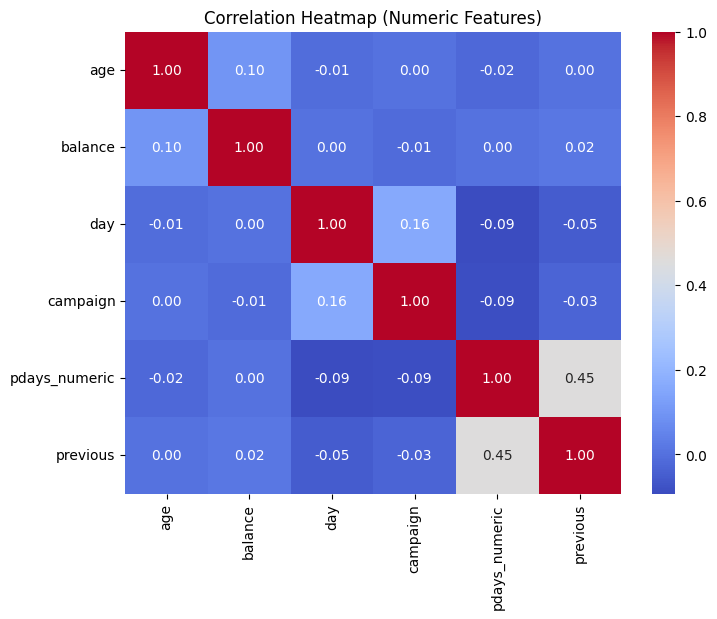

In [ ]:
# Correlation
corr = df_train[num_features].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


We are trying to understand the numerical features in this section:
- How are the features distributed? Do they show any skewness?
- What are the correlations among the features?
- This will help us make better judgments on whether remove outliers, normalize, or remove similar features.

From the box plot and the distribution graphs
- Age       : that looks ok, with outliers
- Balance   : most people fill in 0, maybe people over look this section
- Day       : no outliers, good distribution
- Duration  : dropped due to data leakage
- Campaign  : more than 6 calls during a campain and that would be too many call for one personm > skewed right
- Pdays = contacted_before + pdays_numeric bc -1 means client was not previously contacted, there are too many -1 (81.7%) > skewed right
- Previous  : most clients are new (81.7%) > skewed right

Notes:
- From the correlation heatmap, most features are not correlated to anothers so we can keep them all

Actions
- Age           : StandardScaler
- Balance       : Skewed right with negative values > StandardScaler
- Day           : StandardScaler
- Campaign      : log1p transformed > StandardScaler
- pdays_numeric : log1p transformed > StandardScaler
- previous      : log1p transformed > StandardScaler

What is log1p transform?
- Reduces skewness
- Makes the distribution more normal-like
- Helps with logistic regression

# Categorical features Visualization

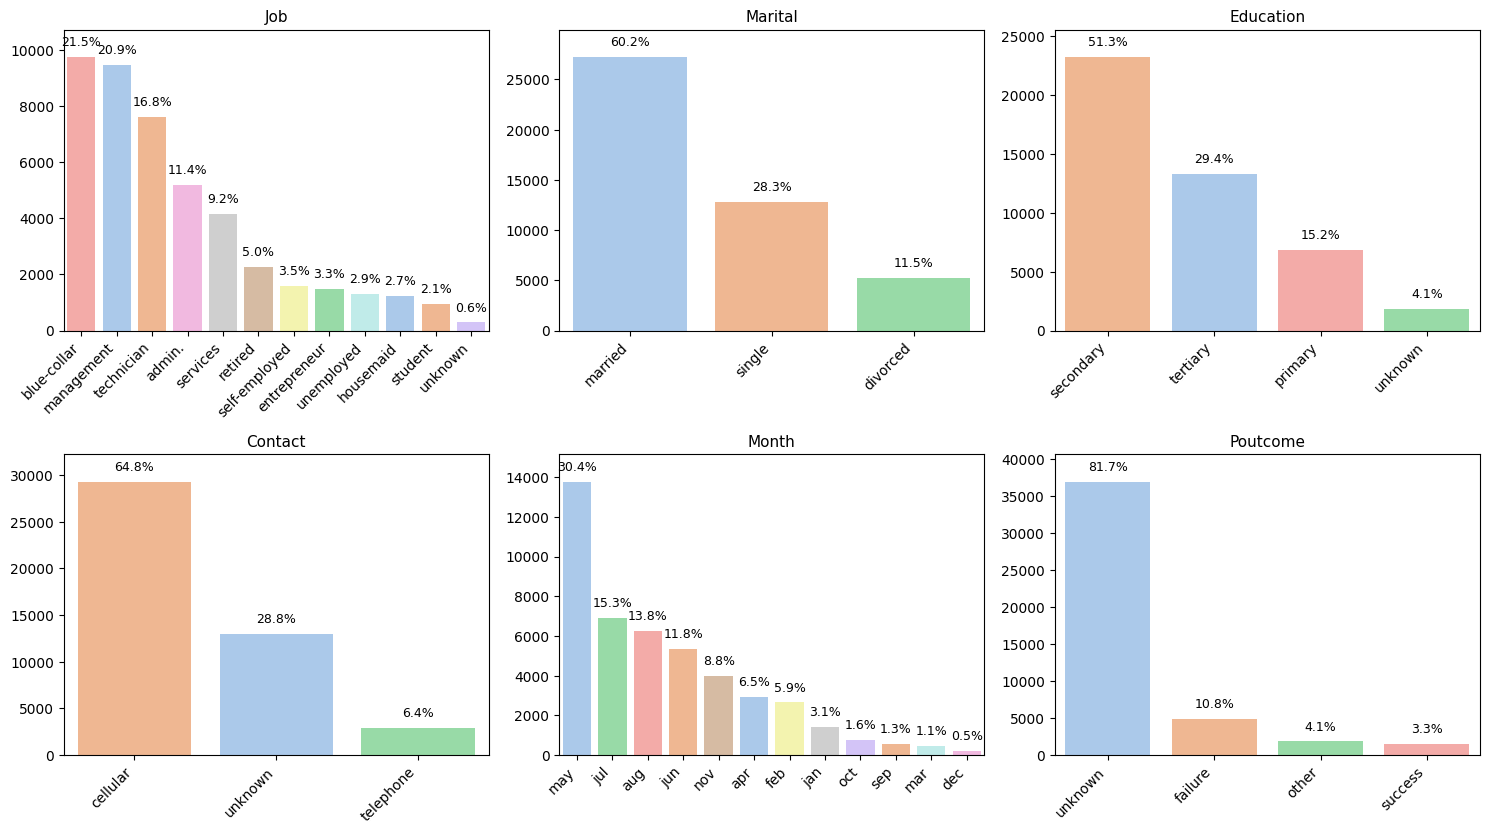

In [ ]:
# Graphs
# Number of plots
n     = len(cat_features)             # 10
ncols = 3                         # 3 columns
nrows = n // ncols + 1            # 10 // 3 + 1 = 4

plt.figure(figsize=(5*ncols, 4*nrows))

for i, col in enumerate(cat_features, 1):
    plt.subplot(nrows, ncols, i)
    ax = sns.countplot(
        x=col,
        hue=col,
        data=df_train,
        palette='pastel',
        order=df_train[col].value_counts().index,
        legend=False
    )

    total = len(df_train)

    # find tallest bar to give extra y-axis space
    max_height = max(p.get_height() for p in ax.patches)
    ax.set_ylim(0, max_height * 1.10)  # 15% space above bars

    # annotate each bar
    for p in ax.patches:
        count = p.get_height()
        percentage = 100 * count / total

        # annotate text slightly above bar top
        ax.annotate(
            f'{percentage:.1f}%',
            xy=(p.get_x() + p.get_width() / 2., p.get_height()),
            xytext=(0, 6),                  # 6 points above the bar
            textcoords='offset points',
            ha='center', va='bottom',
            fontsize=9, color='black'
        )

    plt.title(col.capitalize(), fontsize=11)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

From the bar charts:
- There are some dominant responses among the features; during training, the classes(freatures) will therefore be weighted.

What is Cramér’s V correlation coefficient?
- It measures the strength of association between two categorical variables.


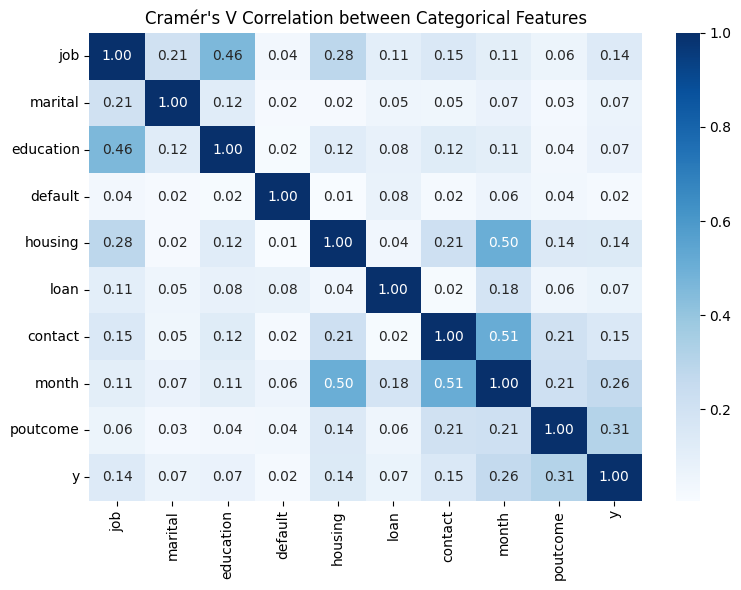

In [ ]:
def cramers_v(x, y):
    table = pd.crosstab(x, y)
    chi2  = chi2_contingency(table, correction = False)[0]
    n     = table.sum().sum()
    k     = min(table.shape)
    return np.sqrt(chi2 / (n * (k - 1)))

# build the matrix
cramers = pd.DataFrame(index = cat_features, columns=cat_features, dtype=float)

for c1 in cat_features:
    for c2 in cat_features:
        cramers.loc[c1, c2] = cramers_v(df_train[c1], df_train[c2])

# visualize
plt.figure(figsize=(8,6))
sns.heatmap(cramers.astype(float), annot=True, cmap='Blues', fmt=".2f")
plt.title("Cramér's V Correlation between Categorical Features")
plt.tight_layout()
plt.show()


From the Cramer's V heat map
- There is no strong correlation among features
- 0.5 and 0.46 are the two most significant values
- education and job are kind of related - if you are in school > you are a student
- month and housing - in the summer, people are just happy to go buy a house
- month and contact - in the summer, people are just happy to pickup the phone

# Train/Test split

In [111]:
# 70% train / 30% internal test (keep separate test.csv untouched)
X = df_train[num_features + cat_features + bin_features]
y = df_train["y"].astype(int)

# We are using StratifiedShuffleSplit so no need to use train_test_split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.30, stratify=y, random_state=1972
# )

In [112]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Preprocessing

In [113]:
# Imputer + Scaler are placed in every pipeline to avoid leakage and for consistent processing.
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

In [115]:
numeric_transformer = Pipeline(
    steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(
    steps=[
      ("imputer", SimpleImputer(strategy="most_frequent")),
      ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

In [116]:
# Preprocessing transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features),
        ('bin', 'passthrough', bin_features),
    ],
    remainder='drop'
)

# Results

In [117]:
results = []

### After the proprocessing, everyone can do what ever they want

In [ ]:
# train.csv > train_set + test_set (70/30) use shuffle

# 1. internal testing for the test_set

# 2. external testing using test.csv

# Compare 1 vs 2

# Kelvin
### Output -Table for internal testing vs external testing - accuracy, f1, roc

# Logistic Regression(Sri), Random Forest(Spandana)

## Pipeline

In [118]:
# creating pipelines
lr_pipe = Pipeline(steps =[
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(max_iter=2000))])

rf_pipe = Pipeline([
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
])

## Parameter Grid

In [119]:
# Parameters for Logistic Regression
lr_param_grid = {
  'clf__C': [0.01, 0.1, 1, 10, 100],
}

rf_param_grid = {
    'clf__n_estimators': [100, 150],          # Moderate number
    'clf__max_depth': [12, 15],               # Limited depth
    'clf__min_samples_split': [10, 15],       # Higher values = less overfitting
    'clf__min_samples_leaf': [5, 7],          # Larger leaves = smoother model
    'clf__max_features': ['sqrt'],
}


# Optional
# print("\n[Hyperparameter Grid]")
# for param, values in rf_param_grid.items():
#     print(f"  {param}: {values}")
# print(f"Total combinations: {len(rf_param_grid['clf__n_estimators']) * len(rf_param_grid['clf__max_depth']) * len(rf_param_grid['clf__min_samples_split'])}")


## StratifiedKFold

In [120]:
# creating 2 seperate because this avoids optimistic bias because you evaluate on folds that the model has not seen during hyperparameter tuning.
# use the different random_state, otherwise the folds will still be identical.

# creating a StratifiedKFold classifier to train the models
cv_tune = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# creating a StratifiedKFold classifier for Cross Validation
cv_eval = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

## GridSearchCV

In [121]:
gs_lr = GridSearchCV(lr_pipe, lr_param_grid, cv = cv_tune, scoring='f1_weighted', n_jobs=-1)



gs_rf = GridSearchCV(
    rf_pipe,
    rf_param_grid,
    cv      =cv_tune,
    scoring ='f1_weighted',
    n_jobs  =-1,
    verbose =1
)

## Fit Models

In [122]:
# Logistic Regression model Fit
gs_lr.fit(X_train, y_train)

# Random Forest model Fit
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'balance',
                                                                          'day',
                                                                          'campaign',
                                                                          'pdays_numeric',
                                                                          'previous']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImpu...
                                                                          'poutcome']),
                                                                        ('bin',
                                                                         'passthrough',
                                                                         ['default',
                                                                          'housing',
                                                                          'loan'])])),
                                       ('clf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [12, 15],
                         'clf__max_features': ['sqrt'],
                         'clf__min_samples_leaf': [5, 7],
                         'clf__min_samples_split': [10, 15],
                         'clf__n_estimators': [100, 150]},
             scoring='f1_weighted', verbose=1)

## Best Estimator

In [123]:
best_lr = gs_lr.best_estimator_ # Best Logistic Regression Estimator

best_rf = gs_rf.best_estimator_ # Best Random Forest Estimator

## Cross Validation

In [130]:
def run_cv(model_name, model, X_train, y_train, cv, scoring = None, return_train_score=False):
  if scoring is None:
    scoring = ["accuracy", "f1_weighted", "roc_auc_ovr_weighted"]
  scores = cross_validate(best_lr, X_train, y_train, cv=cv_eval, scoring=scoring, return_train_score=False)
  return ({
      "Model": model_name,
      "Accuracy Mean ± Std": f'{np.mean(scores["test_accuracy"]):.4f} ± {np.std(scores["test_accuracy"], ddof=1):.4f}',
      "F1 Mean  ± Std": f'{np.mean(scores["test_f1_weighted"]):.4f} ± {np.std(scores["test_f1_weighted"], ddof=1):.4f}',
      "AUC-ROC Mean  ± Std": f'{np.mean(scores["test_roc_auc_ovr_weighted"]):.4f} ± {np.std(scores["test_roc_auc_ovr_weighted"], ddof=1):.4f}'
  })

In [131]:
scores_lr = run_cv("Logistic", best_lr, X_train, y_train, cv=cv_eval)

print("----------------- Logistic Regression ---------------------------")
print(pd.DataFrame([scores_lr]))

scores_rf = run_cv("Random Forest", best_rf, X_train, y_train, cv=cv_eval)
print("----------------- Random Forest -----------------------------------")
print(pd.DataFrame([scores_rf]))

----------------- Logistic Regression ---------------------------
      Model Accuracy Mean ± Std   F1 Mean  ± Std AUC-ROC Mean  ± Std
0  Logistic     0.8922 ± 0.0018  0.8637 ± 0.0020     0.7644 ± 0.0057
----------------- Random Forest -----------------------------------
           Model Accuracy Mean ± Std   F1 Mean  ± Std AUC-ROC Mean  ± Std
0  Random Forest     0.8922 ± 0.0018  0.8637 ± 0.0020     0.7644 ± 0.0057


## Prediction

In [132]:
# Predictions
y_pred_lr = best_lr.predict(X_test)
y_proba_lr = best_lr.predict_proba(X_test)

y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)

## Accuracy, F1_score, roc_auc_score

In [135]:
def print_acc_f1_roc(y_test, y_pred, y_proba):
  # Accuracy
  internal_accuracy = accuracy_score(y_test, y_pred)

  # F1 Score (weighted for multiclass safety)
  internal_f1 = f1_score(y_test, y_pred, average='weighted', pos_label=1)

  # ROC-AUC binary
  internal_auc = roc_auc_score(y_test, y_proba[:, 1])

  # Confusion Matrix
  cm = confusion_matrix(y_test, y_pred)

  # Classification Report
  report = classification_report(y_test, y_pred)

  print("----- INTERNAL TEST RESULTS -----")
  print(f"Test Accuracy: {internal_accuracy:.4f}")
  print(f"Test F1 Score: {internal_f1:.4f}")
  print(f"Test ROC-AUC: {internal_auc:.4f}\n")

  print("\nClassification report:\n", report)

  print("Confusion Matrix:\n", cm)

  # return internal_accuracy, internal_f1, internal_auc


In [136]:
print_acc_f1_roc(y_test, y_pred_lr, y_proba_lr)


print_acc_f1_roc(y_test, y_pred_rf, y_proba_rf)


----- INTERNAL TEST RESULTS -----
Test Accuracy: 0.8935
Test F1 Score: 0.8652
Test ROC-AUC: 0.7719


Classification report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94      7985
           1       0.67      0.18      0.28      1058

    accuracy                           0.89      9043
   macro avg       0.78      0.58      0.61      9043
weighted avg       0.87      0.89      0.87      9043

Confusion Matrix:
 [[7891   94]
 [ 869  189]]
----- INTERNAL TEST RESULTS -----
Test Accuracy: 0.8450
Test F1 Score: 0.8576
Test ROC-AUC: 0.8029


Classification report:
               precision    recall  f1-score   support

           0       0.94      0.88      0.91      7985
           1       0.39      0.58      0.47      1058

    accuracy                           0.84      9043
   macro avg       0.67      0.73      0.69      9043
weighted avg       0.88      0.84      0.86      9043

Confusion Matrix:
 [[7026  959]
 [ 443  615]]


## EXTERNAL TEST

In [137]:
X_test = df_test[num_features + cat_features + bin_features]
y_test = df_test['y'].astype(int)

In [138]:
# Predictions
y_pred_lr = best_lr.predict(X_test)
y_proba_lr = best_lr.predict_proba(X_test)

y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)


In [139]:
print_acc_f1_roc(y_test, y_pred_lr, y_proba_lr)

print_acc_f1_roc(y_test, y_pred_rf, y_proba_rf)

----- INTERNAL TEST RESULTS -----
Test Accuracy: 0.8901
Test F1 Score: 0.8583
Test ROC-AUC: 0.7335


Classification report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94      4000
           1       0.60      0.14      0.22       521

    accuracy                           0.89      4521
   macro avg       0.75      0.56      0.58      4521
weighted avg       0.86      0.89      0.86      4521

Confusion Matrix:
 [[3952   48]
 [ 449   72]]
----- INTERNAL TEST RESULTS -----
Test Accuracy: 0.8551
Test F1 Score: 0.8668
Test ROC-AUC: 0.8630


Classification report:
               precision    recall  f1-score   support

           0       0.95      0.89      0.92      4000
           1       0.41      0.61      0.49       521

    accuracy                           0.86      4521
   macro avg       0.68      0.75      0.70      4521
weighted avg       0.88      0.86      0.87      4521

Confusion Matrix:
 [[3547  453]
 [ 202  319]]


## Plotting ROC_Curve

In [140]:
# Dictionary of models
models = {
    "Logistic Regression": best_lr,
    "Random Forest": best_rf
}

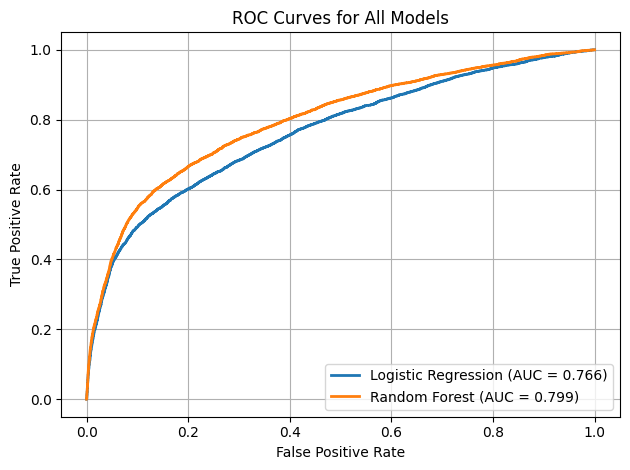

In [143]:
for name, model in models.items():
    y_true_all = []
    y_prob_all = []

    for train_idx, test_idx in cv_eval.split(X, y):
        est = clone(model)
        est.fit(X.iloc[train_idx], y.iloc[train_idx])

        # Predict probabilities for class 1
        if hasattr(est, "predict_proba"):
            y_prob = est.predict_proba(X.iloc[test_idx])[:, 1]
        elif hasattr(est, "decision_function"):
            y_prob = est.decision_function(X.iloc[test_idx])
        else:
            y_prob = est.predict(X.iloc[test_idx])  # fallback

        y_true_all.append(y.iloc[test_idx])
        y_prob_all.append(y_prob)

    # Concatenate results from all folds
    y_true_concat = np.concatenate(y_true_all)
    y_prob_concat = np.concatenate(y_prob_all)

    fpr, tpr, _ = roc_curve(y_true_concat, y_prob_concat)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Hoan
### Output -Table for internal testing vs external testing - accuracy, f1, roc

## Random Forest - San

In [ ]:
# Imputer + Scaler are placed in every pipeline to avoid leakage and for consistent processing.
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

## Pipeline

In [ ]:
rf_pipe = Pipeline([
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
])

## Parameter Grid

In [ ]:
rf_param_grid = {
    'clf__n_estimators': [100, 150],          # Moderate number
    'clf__max_depth': [12, 15],               # Limited depth
    'clf__min_samples_split': [10, 15],       # Higher values = less overfitting
    'clf__min_samples_leaf': [5, 7],          # Larger leaves = smoother model
    'clf__max_features': ['sqrt'],
}

print("\n[Hyperparameter Grid]")
for param, values in rf_param_grid.items():
    print(f"  {param}: {values}")
print(f"Total combinations: {len(rf_param_grid['clf__n_estimators']) * len(rf_param_grid['clf__max_depth']) * len(rf_param_grid['clf__min_samples_split'])}")


## StratifiedKFold

In [ ]:
cv_model = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## GridSearch CV

In [ ]:
gs_rf = GridSearchCV(
    rf_pipe,
    rf_param_grid,
    cv=cv_model,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# San
### Output -Table for internal testing vs external testing - accuracy, f1, roc

In [ ]:
def run_cv(model, df: pd.DataFrame, target: str, name: str, cv=5):

    df = df.copy()
    y  = df[target]
    X  = df.drop(columns=[target])

    scoring = {
        "accuracy" : make_scorer(accuracy_score),
        "precision": make_scorer(precision_score),
        "recall"   : make_scorer(recall_score),
        "f1"       : make_scorer(f1_score),
        "auc"      : 'roc_auc',
    }

    # Stratified keeps the class (yes/no) proportions the same in every fold
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    cvres = cross_validate(
        model, X, y,
        scoring = scoring,
        cv      = skf,
    )

    return dict(
        Model     = name,
        Accuracy  = cvres["test_accuracy"].mean(),
        Precision = cvres["test_precision"].mean(),
        Recall    = cvres["test_recall"].mean(),
        F1        = cvres["test_f1"].mean(),
        AUC       = cvres["test_auc"].mean(),
    )

In [ ]:
df_train.columns = df_train.columns.str.strip()
df_test.columns = df_test.columns.str.strip()

# Data Splitting

In [ ]:
# Split into features & labels
X_train = df_train.drop("y", axis=1)
y_train = df_train["y"]

X_test = df_test.drop("y", axis=1)
y_test = df_test["y"]


In [ ]:
results = []

for name, model in models.items():
  pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
  ])
  pipe.fit(X_train, y_train)
  y_pred = pipe.predict(X_test)
  y_pred_proba = pipe.predict_proba(X_test)[:, 1]
  metrics = {
    "Model"   : name,
    "Accuracy": accuracy_score(y_test, y_pred),
    "AUC-ROC" : roc_auc_score(y_test, y_pred_proba),
    "Precision" : precision_score(y_test, y_pred, pos_label=1),
    "Recall" : recall_score(y_test, y_pred, pos_label=1),
    "F1" : f1_score(y_test, y_pred, pos_label=1)
  }
  results.append(metrics)
  # if name in ["Logistic Regression", "Naive Bayes"]:
  #   metrics = run_cv(model, df_L_N_train, 'y', name)
  # else:
  #   metrics = run_cv(model, df_R_X_train, 'y', name)

In [ ]:
# Create comparison table
df_results = pd.DataFrame(results).sort_values(by="F1", ascending=False)
print(df_results)

                 Model  Accuracy   AUC-ROC  Precision    Recall        F1
2        Random Forest  1.000000  1.000000   1.000000  1.000000  1.000000
3              XGBoost  0.905773  0.979266   0.551463  0.976967  0.704986
0  Logistic Regression  0.835656  0.901101   0.394286  0.794626  0.527053
1          Naive Bayes  0.847821  0.792567   0.374436  0.477927  0.419899


In [ ]:
# Imports should be in there own area if possible
# Dont do everything in the same area
# Make smaller steps
##############################
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize

##############################

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_cols),

        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ]
)

# Imputer + Scaler are placed in every pipeline to avoid leakage and for consistent processing.
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

# creating pipelines

lr_pipe = Pipeline([('preprocess', preprocessor), ('clf', LogisticRegression(max_iter=2000))])

# Parameters for Logistic Regression
lr_param_grid = {
  'clf__C': [0.01, 0.1, 1, 10, 100],
}

# creating a StratifiedKFold classifier to train the models
cv_model = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# creating a StratifiedKFold classifier for Cross Validation
cv_validation = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs_lr = GridSearchCV(lr_pipe, lr_param_grid, cv = cv_model, scoring='f1_weighted', n_jobs=-1)
gs_lr.fit(X_train, y_train)
best_lr = gs_lr.best_estimator_

results = []
scoring = ["accuracy", "f1_weighted", "roc_auc_ovr_weighted"]


scores = cross_validate(best_lr, X_train, y_train, cv=cv_validation, scoring=scoring, return_train_score=False)

results.append({
    "Model": "Logistic",
    "Accuracy Mean": np.mean(scores["test_accuracy"]),
    "Accuracy Std": np.std(scores["test_accuracy"], ddof=1),
    "F1 Mean": np.mean(scores["test_f1_weighted"]),
    "F1 Std": np.std(scores["test_f1_weighted"], ddof=1),
    "AUC-ROC Mean": np.mean(scores["test_roc_auc_ovr_weighted"]),
    "AUC-ROC Std": np.std(scores["test_roc_auc_ovr_weighted"], ddof=1)
})

# Converting results into DataFrame
metrics_table = pd.DataFrame(results)
print(metrics_table)

# Predictions
y_pred = best_lr.predict(X_test)
y_proba = best_lr.predict_proba(X_test)

# Accuracy
test_accuracy = accuracy_score(y_test, y_pred)

# F1 Score (weighted for multiclass safety)
test_f1 = f1_score(y_test, y_pred, average='weighted')

# ROC-AUC (handles binary or multiclass)
if len(np.unique(y_test)) == 2:
    # binary
    test_auc = roc_auc_score(y_test, y_proba[:, 1])
else:
    # multiclass
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    test_auc = roc_auc_score(y_test_bin, y_proba, average='weighted', multi_class='ovr')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Classification Report
report = classification_report(y_test, y_pred)

print("----- FINAL TEST RESULTS -----")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test ROC-AUC: {test_auc:.4f}\n")

print("Confusion Matrix:")
print(cm, "\n")

print("Classification Report:")
print(report)

      Model  Accuracy Mean  Accuracy Std   F1 Mean    F1 Std  AUC-ROC Mean  \
0  Logistic       0.901573      0.002036  0.888057  0.002028      0.906496   

   AUC-ROC Std  
0     0.005632  
----- FINAL TEST RESULTS -----
Test Accuracy: 0.9020
Test F1 Score: 0.8878
Test ROC-AUC: 0.8967

Confusion Matrix:
[[3905   95]
 [ 348  173]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4000
           1       0.65      0.33      0.44       521

    accuracy                           0.90      4521
   macro avg       0.78      0.65      0.69      4521
weighted avg       0.89      0.90      0.89      4521



# GaussianNB - Hoan Lam

### Load Data

### Helpers

In [ ]:
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 5.0 MB/s eta 0:00:00


In [ ]:
# IAMB implementation with partial correlation
# def iamb

# Credited
# https://dev.to/ogambakerubo/feature-selection-with-the-iamb-algorithm-a-casual-dive-into-machine-learning-53a7

import pingouin as pg

def iamb(data, target, alpha=0.05):

  markov_blanket = set()

  # Forward Phase
  for feature in data.columns:
    if feature != target:

      # partial_corr
      # ex:
      #            n         r         CI95%         p-val
      # pearson  768  0.221898  [0.15, 0.29]  5.065127e-10
      #
      # n     - number of valid samples used
      # r     - partial correlations strength
      # CI95% - 95% confidence interval for r
      # p-val - Probability that the observed r occurred by chance if there's no real relationship

      partial_corr  = pg.partial_corr(data=data, x=feature, y=target, covar=markov_blanket)
      p_value       = partial_corr['p-val'].iloc[0]

      # p-value > 0.05 - Could just be randome noise > Ignore feature
      # p-value < 0.05 - Probably meaningful > Keep feature
      if p_value < alpha:
        markov_blanket.add(feature)

  print("Selected Features after Forward Phase :", markov_blanket)

  # Backward Phase
  for feature in list(markov_blanket):
    reduced_mb    = markov_blanket - {feature}
    partial_corr  = pg.partial_corr(data=data, x=feature, y=target, covar=reduced_mb)
    p_value       = partial_corr['p-val'].iloc[0]
    if p_value > alpha:
      markov_blanket.remove(feature)

  print("Selected Features after Backward Phase :", markov_blanket)
  return list(markov_blanket)


# Run cross validation
def run_cv(model, X, y, name: str, cv=5):
  scoring = {
    "accuracy" : make_scorer(accuracy_score),
    "precision": make_scorer(precision_score),
    "recall"   : make_scorer(recall_score),
    "f1"       : make_scorer(f1_score),
    "auc"      : "roc_auc",
  }

  skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

  cvres = cross_validate(
    model, X, y,
    scoring = scoring,
    cv      = skf,
  )

  return dict(
    Model     = name,
    Accuracy  = cvres["test_accuracy"].mean(),
    Precision = cvres["test_precision"].mean(),
    Recall    = cvres["test_recall"].mean(),
    F1        = cvres["test_f1"].mean(),
    AUC       = cvres["test_auc"].mean(),
  )

### Apply IAMB

In [ ]:
selected_features = iamb(df_L_N_train, 'y', alpha=0.05)

Selected Features after Forward Phase : {'month_jan', 'default', 'campaign', 'poutcome_other', 'loan', 'pdays_numeric', 'month_jun', 'job_blue-collar', 'balance', 'month_apr', 'poutcome_success', 'job_technician', 'job_housemaid', 'marital_married', 'education_tertiary', 'job_student', 'poutcome_failure', 'job_unknown', 'month_mar', 'job_retired', 'education_primary', 'month_aug', 'previous', 'age', 'contact_cellular', 'marital_single', 'contact_unknown', 'contacted_before', 'day', 'job_services', 'month_jul', 'month_nov', 'month_dec', 'housing', 'job_entrepreneur', 'month_feb', 'month_may', 'contact_telephone', 'education_secondary'}
Selected Features after Backward Phase : {'month_jan', 'campaign', 'loan', 'pdays_numeric', 'month_jun', 'balance', 'month_apr', 'poutcome_success', 'job_housemaid', 'marital_married', 'job_student', 'poutcome_failure', 'month_mar', 'job_retired', 'education_primary', 'month_aug', 'previous', 'contact_cellular', 'contact_unknown', 'contacted_before', 'day

In [ ]:
new_df_L_N_train = df_L_N_train[selected_features].assign(y=df_L_N_train['y'])

In [ ]:
# IAMB results - 49 features > 28 features

In [ ]:
display(df_L_N_train.shape)
df_L_N_train.head()

(45211, 49)

,age,default,balance,housing,loan,day,campaign,previous,y,contacted_before,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,1.606965,0,0.256419,1,0,-1.298476,-0.909457,-0.424616,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.288529,0,-0.437895,1,0,-1.298476,-0.909457,-0.424616,0,0,...,0,0,1,0,0,0,0,0,0,1
2,-0.747384,0,-0.446762,1,1,-1.298476,-0.909457,-0.424616,0,0,...,0,0,1,0,0,0,0,0,0,1
3,0.571051,0,0.047205,1,0,-1.298476,-0.909457,-0.424616,0,0,...,0,0,1,0,0,0,0,0,0,1
4,-0.747384,0,-0.447091,0,0,-1.298476,-0.909457,-0.424616,0,0,...,0,0,1,0,0,0,0,0,0,1


In [ ]:
display(new_df_L_N_train.shape)
new_df_L_N_train.head()

(45211, 29)

,month_jan,campaign,loan,pdays_numeric,month_jun,balance,month_apr,poutcome_success,job_housemaid,marital_married,...,contacted_before,day,month_jul,month_nov,housing,month_feb,month_may,contact_telephone,education_secondary,y
0,0,-0.909457,0,-0.467314,0,0.256419,0,0,0,1,...,0,-1.298476,0,0,1,0,1,0,0,0
1,0,-0.909457,0,-0.467314,0,-0.437895,0,0,0,0,...,0,-1.298476,0,0,1,0,1,0,1,0
2,0,-0.909457,1,-0.467314,0,-0.446762,0,0,0,1,...,0,-1.298476,0,0,1,0,1,0,1,0
3,0,-0.909457,0,-0.467314,0,0.047205,0,0,0,1,...,0,-1.298476,0,0,1,0,1,0,0,0
4,0,-0.909457,0,-0.467314,0,-0.447091,0,0,0,0,...,0,-1.298476,0,0,0,0,1,0,0,0


### Checking if test.csv a subset of train.csv - It is sadly

In [ ]:
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

In [ ]:
is_subset = test.merge(train.drop_duplicates(), how="left", indicator=True)["_merge"].eq("both").all()
print("Test ⊆ Train ?", is_subset)

Test ⊆ Train ? True


### Since test.csv is a subset of train.csv > going to split the training into training and testing

In [ ]:
from sklearn.model_selection import train_test_split

# Split data
X = df_L_N_train.drop('y', axis=1)
y = df_L_N_train['y']

X_train, X_test, y_train, y_test = train_test_split(
  X, y,
  test_size=0.3,
  random_state=42,
  stratify=y          # this ensures the class proportion in train and test matches the original
)

X_train_selected  = X_train[selected_features]
X_test_selected   = X_test[selected_features]

### GaussianNB Models

In [ ]:
gnb_1 = GaussianNB()  # ALl features
gnb_2 = GaussianNB()  # Selected features

### Cross validation to average results

In [ ]:
results = []
for name, model in [
  ("Naive Bayes", gnb_1),
  ("Naive Bayes IAMB", gnb_2),

]:
  if name in ["Naive Bayes"]:
    metrics = run_cv(model, X_train, y_train, name)
  else:
    metrics = run_cv(model, X_train_selected, y_train, name)
  results.append(metrics)

# Create comparison table
df_results = pd.DataFrame(results).sort_values(by="F1", ascending=False)
print(df_results)

              Model  Accuracy  Precision    Recall        F1       AUC
0       Naive Bayes  0.826808   0.324785  0.445961  0.375602  0.735862
1  Naive Bayes IAMB  0.826619   0.311553  0.398693  0.349633  0.727091


### Models to test on the test set

In [ ]:
from sklearn.metrics import roc_auc_score

# Model with All Features
model_all   = gnb_1
model_all.fit(X_train, y_train)
y_pred_all  = model_all.predict(X_test)

# Model with IAMB-Selected Features
model_iamb  = gnb_2
model_iamb.fit(X_train_selected, y_train)
y_pred_iamb = model_iamb.predict(X_test_selected)

# Evaluate models
results = {
  'Model'   : ['Naive Bayes', 'Naive Bayes IAMB'],
  'Accuracy': [accuracy_score(y_test, y_pred_all), accuracy_score(y_test, y_pred_iamb)],
  'F1 Score': [f1_score(y_test, y_pred_all), f1_score(y_test, y_pred_iamb)],
  'AUC-ROC' : [roc_auc_score(y_test, model_all.predict_proba(X_test)[:, 1]), roc_auc_score(y_test, model_iamb.predict_proba(X_test_selected)[:, 1]),]
}

results_df = pd.DataFrame(results)
print(results_df)

              Model  Accuracy  F1 Score   AUC-ROC
0       Naive Bayes  0.828517  0.382369  0.740632
1  Naive Bayes IAMB  0.830139  0.361419  0.736056
